<a href="https://colab.research.google.com/github/amitsharhcl/fastai-v3/blob/master/Exercise_Tab_(Santander_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Google Mount

###Libraries

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.tabular import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

In [0]:
!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en,en-US;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/10385/298493/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1554807969&Signature=Yuf4JUhkGNHWbR8lnaNLzpov88oZ4IuZDPPzN4kTMoGb0pvu5TwQoU8TTJIua1KWBEMyy26OO30Tya6N5DYD%2FPQqJrgx83Nowz59Be1cV%2BfNll0br%2FbNVnYrtJ%2B5JYvN3eSZsTk07sR%2BmbmhJ4FESp7MkHb1Z6Qmg8dJBMHhG9%2BS5mXo7mZS41bxmxR3wmrJghR4vZfBFijzwXn7S%2FcQQqSL7roHY2yj7jdnQ20DGtRM6WtDoHbuqtx5fhPP3UpEjRSpTOSWU0UCbPGinnJJhTHs9IIZAHseMRunBOpKGrw%2Bg%2BT%2FBtOyC2q%2FhI6NT6Ns4LvgHjSJVJrI0a8pw6%2BIjA%3D%3D&response-content-disposition=attachment%3B+filename%3Dsantander-customer-transaction-prediction.zip' --output 'santander-customer-transaction-prediction.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  244M  100  244M    0     0   140M      0  0:00:01  0:00:01 --:--:--  140M


###Data Load

In [0]:
!mkdir data/santander

In [0]:
!unzip santander-customer-transaction-prediction.zip -d data/santander

Archive:  santander-customer-transaction-prediction.zip
  inflating: data/santander/train.csv  
  inflating: data/santander/sample_submission.csv  
  inflating: data/santander/test.csv  


In [0]:
path = Path('data/santander');path.ls()

[PosixPath('data/santander/sample_submission.csv'),
 PosixPath('data/santander/train.csv'),
 PosixPath('data/santander/test.csv')]

In [0]:
train_df = pd.read_csv(path/'train.csv')

In [0]:
#train_df.drop(columns=['ID_code'],inplace=True)

In [0]:
test_df = pd.read_csv(path/'test.csv')

In [0]:
#test_df.drop(columns=['ID_code'],inplace=True)

In [0]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


###Tabular

In [0]:

dep_var = 'target'
conts =[]
cats =[]
procs = [Normalize]

In [0]:
for c in train_df.columns:
  conts.append(c)
  

In [0]:
conts

['target',
 'var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90'

In [0]:
train_df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [0]:
test_df.columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

###Stratified

In [0]:
a = test_df.columns
t = pd.Index(['target'])
a = a.append(t)



In [0]:
test_probs = np.zeros(200000)
nFolds = 12
BATCH_SIZE = (4096*2)

In [0]:
folds = StratifiedKFold(n_splits=nFolds, shuffle=False, random_state=99999)
for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(train_df.values, train_df['target'].values))):
    valid_idx = val_idx
    data = TabularDataBunch.from_df(path = path,df = train_df[a], 
                                    dep_var = dep_var, valid_idx=valid_idx, procs=procs, 
                                    cat_names=cats,bs=BATCH_SIZE, test_df=test_df)
    learn = tabular_learner(data, layers=[200, 100, 50, 25], metrics= accuracy   ) #100,50,25
    learn.fit_one_cycle(5, 1e-2)
    test_predicts, _ = learn.get_preds(ds_type=DatasetType.Test)
    test_probs += to_np(test_predicts[:, 1])

12it [13:08, 65.89s/it]


In [0]:
test_probs = test_probs/nFolds

In [0]:
test_probs

array([0.245337, 0.217609, 0.075491, 0.102262, ..., 0.016231, 0.00351 , 0.038999, 0.042069])

In [0]:
sub = pd.read_csv(path/'sample_submission.csv')

In [0]:
sub

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0
5,test_5,0
6,test_6,0
7,test_7,0
8,test_8,0
9,test_9,0


In [0]:
sub['target'] = test_probs

In [0]:
sub.describe()

,target
count,200000.000000
mean,0.088193
std,0.148373
min,0.000778
25%,0.013440
50%,0.030703
75%,0.086060
max,0.999961


In [0]:
sub.to_csv('submission6.csv',index=False)

In [0]:
d = pd.read_csv('submission4.csv')

In [0]:
d

,ID_code,target
0,test_0,0.159485
1,test_1,0.195930
2,test_2,0.037208
3,test_3,0.156577
4,test_4,0.046139
5,test_5,0.002123
6,test_6,0.005322
7,test_7,0.114771
8,test_8,0.001620
9,test_9,0.004843


###Normal  Low score....




In [0]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [0]:
data = (TabularList.from_df(train_df, path=path, cat_names=cats, cont_names=conts)
                           .split_by_idx(list(range(80000,100000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test_df)
                           .databunch())

In [0]:
learn = tabular_learner(data, layers=[200,100], callback_fns=AUROC)

In [0]:
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,AUROC,time
0,0.000002,0.000000,1.000000,00:31


In [0]:
learn.save('normal')

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(201, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=201, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [0]:
test_probs = test_probs/nFolds

In [0]:
sub = pd.read_csv(path/'sample_submission.csv')

In [0]:
sub['target'] = test_probs

In [0]:
sub.to_csv('submission3.csv',index=False)

###Feature Eng

In [0]:
features = list(test_df.columns)
len(features)

200

In [0]:
df_summary = train_df.describe(); df_summary

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [0]:
dmean, dmin, dmax = df_summary.loc['mean'],df_summary.loc['min'], df_summary.loc['max'] 
drange = dmax - dmin

In [0]:
train_df.loc[:, features] = (train_df[features] - dmin[features])/drange[features]
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,0.515985,0.527761,0.498848,0.516818,0.517698,0.551997,0.501877,0.501123,0.522330,...,0.532601,0.521950,0.470032,0.502746,0.483477,0.536917,0.507605,0.488022,0.483899,0.527460
std,0.300653,0.152716,0.159324,0.153221,0.154463,0.139968,0.157852,0.142057,0.152988,0.161333,...,0.140158,0.155773,0.121015,0.132779,0.162998,0.149925,0.167666,0.152592,0.152223,0.154974
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.404160,0.405322,0.383234,0.400217,0.414637,0.428839,0.396761,0.384659,0.396368,...,0.431376,0.404422,0.385063,0.411373,0.360573,0.429027,0.376952,0.379516,0.380712,0.410436
50%,0.000000,0.508191,0.528530,0.491004,0.518970,0.520277,0.556658,0.497967,0.497138,0.527633,...,0.531653,0.517279,0.467860,0.504894,0.481614,0.533706,0.510850,0.484718,0.487100,0.534987
75%,0.000000,0.620387,0.645236,0.603369,0.632294,0.619692,0.672246,0.599256,0.615573,0.650798,...,0.630091,0.628818,0.553659,0.598340,0.608396,0.638836,0.638353,0.601460,0.594820,0.648661
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
test_df.loc[:, features] = (test_df[features] - dmin[features])/drange[features]
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.514922,0.527893,0.498399,0.516190,0.517531,0.552293,0.502896,0.500376,0.521990,0.501234,...,0.531228,0.522973,0.469877,0.502422,0.483642,0.537801,0.507222,0.488729,0.483821,0.528650
std,0.152548,0.158949,0.152814,0.155174,0.139391,0.157973,0.141743,0.153275,0.161369,0.171567,...,0.139891,0.155872,0.121141,0.132898,0.163283,0.149957,0.167420,0.152473,0.152111,0.154388
min,-0.011037,0.000000,0.013814,0.001346,0.035321,0.096270,-0.021458,0.016292,0.026601,0.037994,...,0.000000,0.014669,0.038766,0.012317,0.035790,0.036617,0.008158,0.034604,0.014393,-0.008982
25%,0.403614,0.406892,0.383995,0.398435,0.415318,0.428817,0.397564,0.384216,0.397041,0.369535,...,0.430264,0.404891,0.384506,0.411472,0.360831,0.430076,0.376901,0.380720,0.381600,0.411691
50%,0.507641,0.529221,0.489884,0.518770,0.519545,0.556638,0.499033,0.495611,0.526582,0.509951,...,0.530386,0.518889,0.467148,0.505964,0.482635,0.534828,0.510687,0.485480,0.487573,0.536377
75%,0.619453,0.644637,0.602111,0.632558,0.619026,0.672603,0.599715,0.615200,0.650417,0.642655,...,0.627948,0.629775,0.554191,0.597289,0.608146,0.639707,0.637218,0.601891,0.593833,0.650125
max,1.100891,0.960988,0.962932,0.996500,0.945303,1.000042,0.976198,1.026900,0.976482,0.979527,...,1.058956,1.000000,0.967471,0.978407,1.000988,1.028582,0.926200,1.045598,1.023221,0.991191


In [0]:
def augment_df(df):
    
    for feature in features:
        df[f'sq_{feature}'] = df[feature]**2
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
        df[f'repo_sq_{feature}'] = df[f'repo_{feature}']**2
        df[f'cube_{feature}'] = df[feature]**3
#         df[f'repo_cube_{feature}'] = df[f'repo_{feature}']**3
#         df[f'p4_{feature}'] = df[feature]**4
#         df[f'sin_{feature}'] = sin(df[feature])
#         df[f'exp_{feature}'] = exp(df[feature])
#         df[f'log_{feature}'] = df[f'sq_{feature}'].apply(lambda x: 0 if x==0 else log(x))
    df['min'] = df[features].min(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['max'] = df[features].max(axis=1)
    df['sum'] = df[features].sum(axis=1)
    df['median'] = df[features].median(axis=1)
    df['std'] = df[features].std(axis=1)
    df['var'] = df[features].var(axis=1)
    df['abs_sum'] = df[features].abs().sum(axis=1)
    df['abs_mean'] = df[features].abs().mean(axis=1)
    df['abs_median'] = df[features].abs().median(axis=1)
    df['abs_std'] = df[features].abs().std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    
    df['sq_kurt'] = df[[f'sq_{feature}' for feature in features]].kurt(axis=1)  

In [0]:
%%time
augment_df(train_df)
augment_df(test_df)

CPU times: user 1min 29s, sys: 9.04 s, total: 1min 38s
Wall time: 1min 34s


In [0]:
features = list(test_df.columns[:-12])
stats_features = list(test_df.columns[-12:])
num_features = len(features)
num_features

1002

In [0]:
def view_dist(df, columns, row=10, col=10):
    fig, axes = plt.subplots(10,10,figsize=(30,30))
    axes = axes.flatten()
    for col, ax in zip(columns, axes):
        sns.kdeplot(df.loc[df.target==0, col], ax=ax, color='r', label='0')
        sns.kdeplot(df.loc[df.target==1, col], ax=ax, color='b', label='1')
        ax.legend()
        ax.set_title(f'{col}')
        
    plt.show()  

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


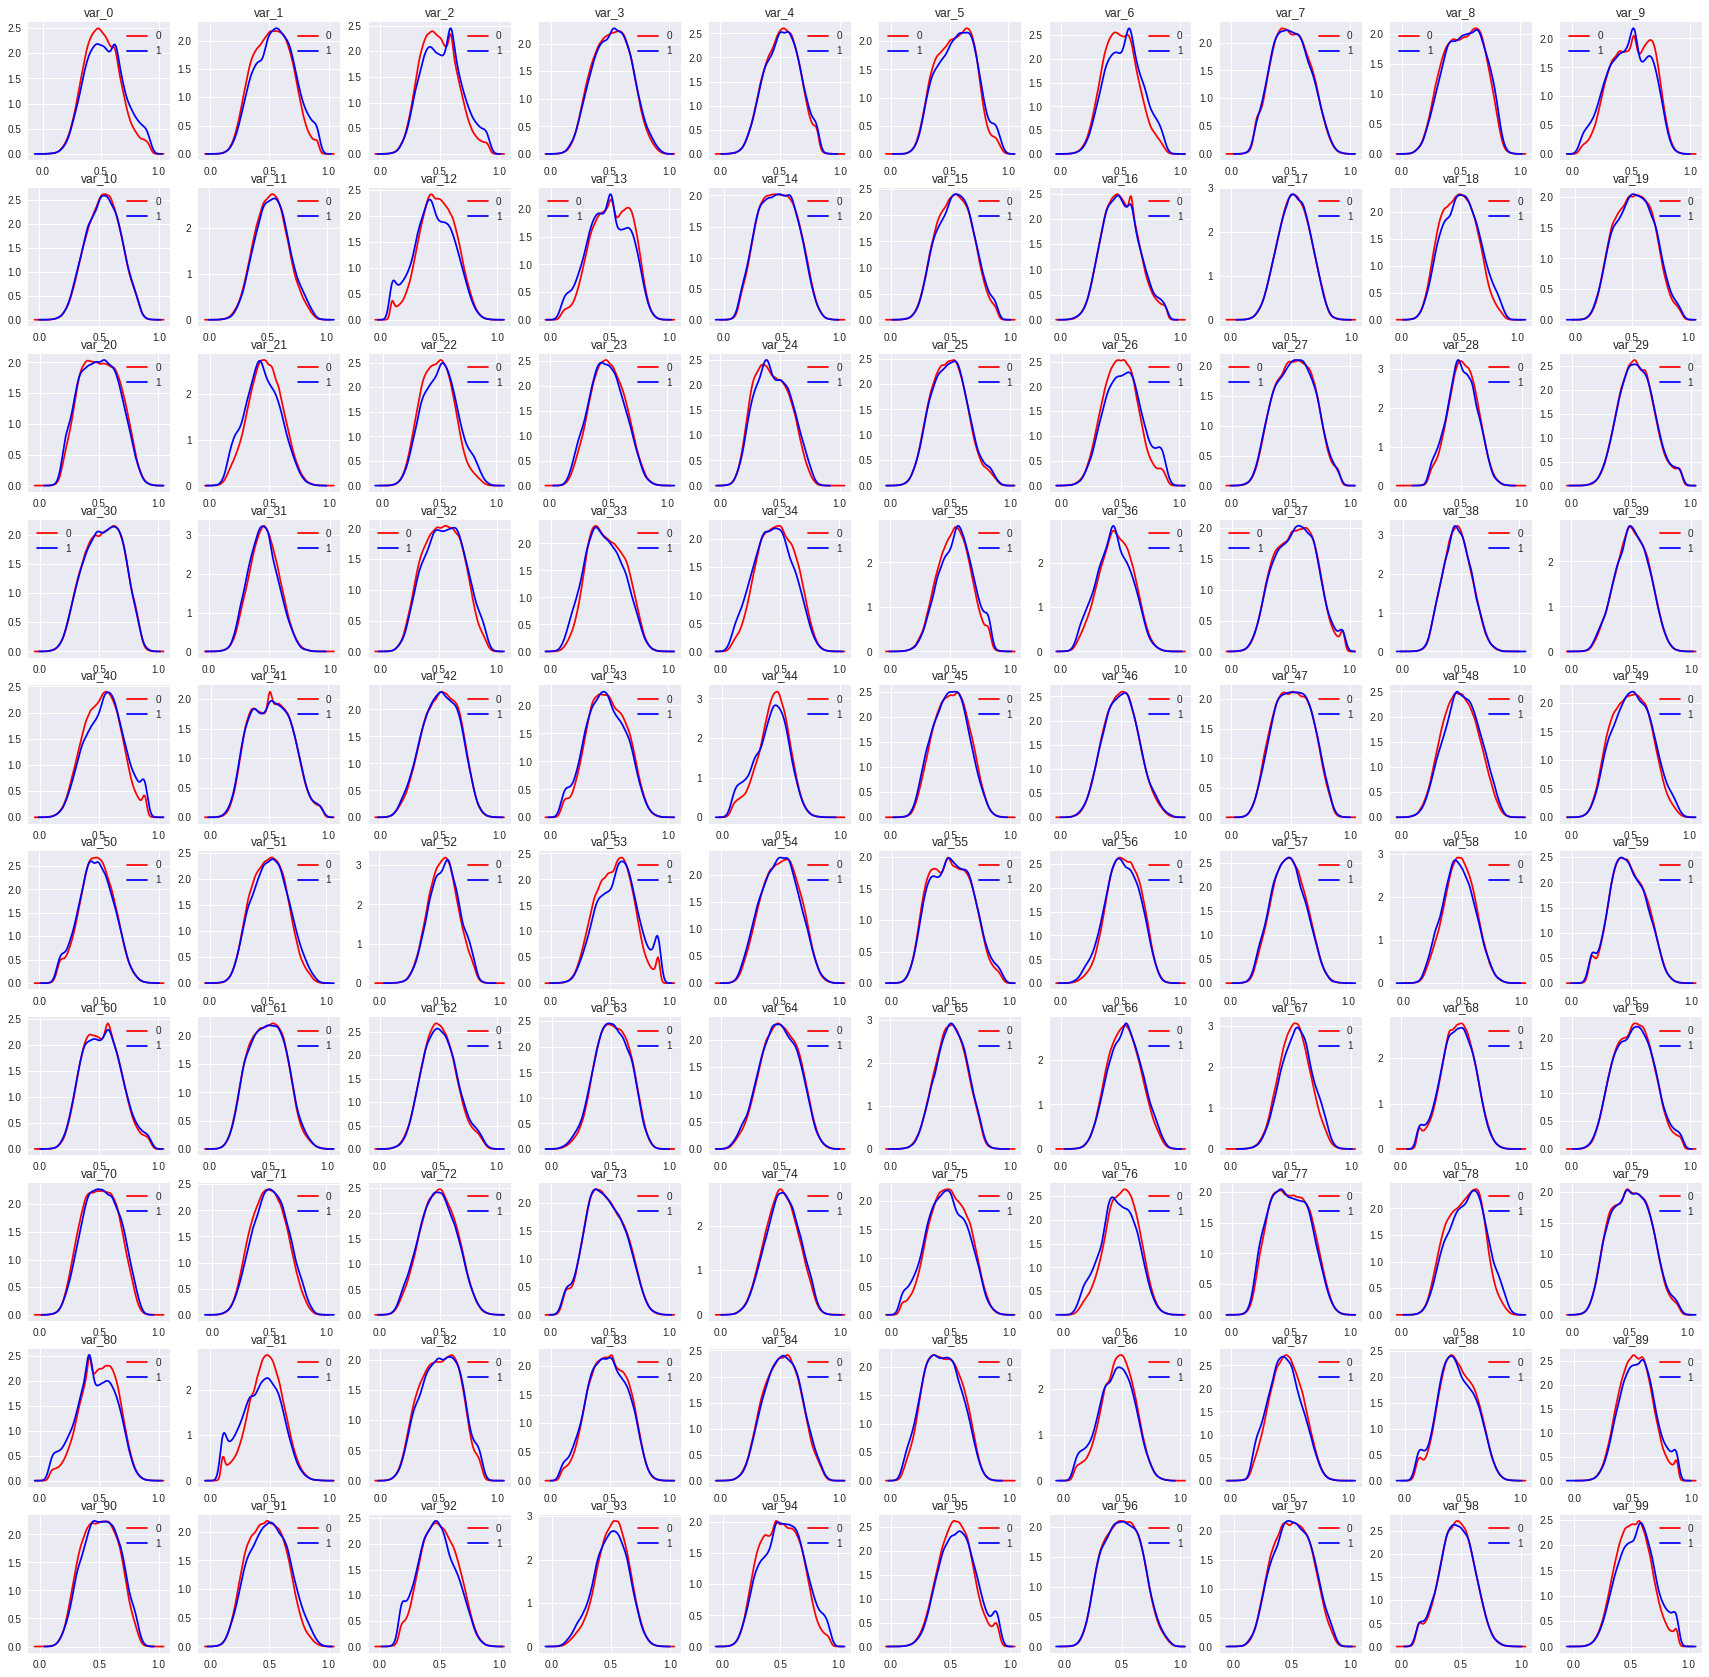

In [0]:

view_dist(train_df, features[:100])

In [0]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [0]:
seed = 2019
train_samples = train_df.sample(frac=0.95, random_state=seed)
valid_samples = train_df.drop(train_samples.index)

In [0]:
random.seed(31415926)
valid_idx = random.sample(list(train_df.index.values), int(len(train_df)*0.2) )
train_idx = train_df.drop(valid_idx).index

In [0]:
train_df.iloc[valid_idx].target.sum() / len(valid_idx) , train_df.target.sum() / len(train_df)

(0.10125, 0.10049)

In [0]:
class roc(Callback):
    '''
    Updated on March 28 2019 to reflect new change in FastAI's Callback
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.total/self.batch_count)

In [0]:
BATCH_SIZE = 1024

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


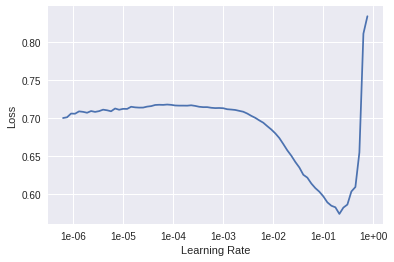

In [0]:
data = TabularDataBunch.from_df(path='.', df=train_df, 
                                 dep_var='target', 
                                 valid_idx=valid_samples.index, 
                                 cat_names=[], 
                                 cont_names=features, 
                                 procs=[tabular.transform.Normalize],
                                 test_df=test_df)

learner = tabular_learner(data, layers=[200,100], ps=[0.5,0.2], metrics=[accuracy, roc()]).to_fp16()

learner.lr_find()
learner.recorder.plot()

In [0]:
def train_and_eval_tabular_learner(train_df,
                                   train_features, 
                                   valid_idx,
                                   add_noise=False,
                                   lr=0.02, epochs=1, layers=[200, 50], ps=[0.5, 0.2], name='learner'):
    
    data = TabularDataBunch.from_df(path='.', df=train_df, 
                                    dep_var='target', 
                                    valid_idx=valid_idx, 
                                    cat_names=[], 
                                    cont_names=train_features, 
                                    bs=BATCH_SIZE,
                                    procs=[],
                                    test_df=test_df)
    learner = tabular_learner(data, layers=layers, ps=ps, metrics=[roc()]).to_fp16()

    learner.fit_one_cycle(epochs, lr)

    # learner.save(name,with_opt=False)
        
    # run prediction on validation set
    valid_predicts, _ = learner.get_preds(ds_type=DatasetType.Valid)
    valid_probs = np.array(valid_predicts[:,1])
    valid_targets = train_df.loc[valid_idx].target.values
    valid_score = roc_auc_score(valid_targets, valid_probs)
    
    # run prediction on test    
    test_predicts, _ = learner.get_preds(ds_type=DatasetType.Test)
    test_probs = to_np(test_predicts[:, 1])

    return valid_score, valid_probs, test_probs

In [0]:
%%time
sub_features = []
valid_scores = []
valid_predictions = []
predictions = []
num_learner = 1000
num_epochs = 5
saved_model_prefix = 'learner'

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 20.5 µs


In [0]:
%%time
for i in range(num_learner):
    print('training model {:}'.format(i))
    sub_features.append(random.sample(list(features), int(num_features*0.5)) + stats_features)
    name = f'{saved_model_prefix}_{i}'

    score, valid_probs, test_probs = train_and_eval_tabular_learner(train_df,
                                                                    sub_features[-1], 
                                                                    valid_idx, 
                                                                    epochs=num_epochs, 
                                                                    lr=0.01, 
                                                                    name=name)
    
    valid_scores.append(score)
    valid_predictions.append(valid_probs)
    predictions.append(test_probs)

training model 0


In [0]:
average_valid_predicts = sum(valid_predictions)/len(valid_predictions)
valid_auc_score = roc_auc_score(df.iloc[valid_idx].target, average_valid_predicts); valid_auc_score

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true=df.iloc[valid_idx].target,y_score=average_valid_predicts)
plt.figure(figsize=(9,9))
plt.plot(fpr, tpr)
plt.show()

In [0]:
# this is if we want to average only on the models that score more than average
# predicts = np.zeros(predictions[0].shape)
# counts = 0
# for i in range(num_epochs):
#     if valid_scores[i] > average_valid_score:
#         predicts += predictions[i]
#         counts += 1
        
# print("number of models: {:}".format(counts))

# predicts = sum(predictions)/counts

In [0]:
test_df['target'] = sum(predictions)/len(valid_predictions)

In [0]:
from datetime import datetime
now = datetime.now()
model_time = now.strftime("%Y%m%d-%H%M")

In [0]:
test_df[['target']].to_csv(f'submission_fastai_ensemble_{model_time}_{valid_auc_score}.csv')

In [0]:
from IPython.display import FileLink
FileLink(f'submission_fastai_ensemble_{model_time}_{valid_auc_score}.csv')

###LGBM

In [0]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns

In [0]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']
print ("Data is ready!")

Data is ready!


In [0]:
train_df.head(15)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


In [0]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [0]:
train_df[train_df['target']==0].describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,179902.0,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,...,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000
mean,0.0,10.626681,-1.695770,10.665876,6.788979,11.072412,-5.146736,5.389620,16.549306,0.262347,...,3.149130,7.390800,1.949017,3.355403,18.017716,-0.155601,2.260297,8.919032,15.924058,-3.415273
std,0.0,3.008564,4.024813,2.612961,2.040082,1.620103,7.827522,0.857983,3.417700,3.331105,...,4.522568,2.997847,1.476456,3.982819,3.127715,1.422275,5.441118,0.917467,2.978539,10.434525
min,0.0,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-10.845500,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.0,8.429500,-4.790775,8.698025,5.247625,9.880600,-11.260950,4.756425,13.950125,-2.342575,...,-0.111850,5.130825,0.915300,0.612400,15.656700,-1.178700,-1.987375,8.262100,13.896000,-11.312025
50%,0.0,10.478600,-1.682600,10.529000,6.817000,11.104400,-4.917700,5.364400,16.460850,0.371400,...,3.117250,7.297000,1.928950,3.417550,17.982400,-0.184200,2.359700,8.897700,15.988500,-2.914000
75%,0.0,12.693075,1.287700,12.463900,8.317875,12.253100,0.844600,5.981300,19.108800,2.919300,...,6.296375,9.461300,2.969800,6.217075,20.417500,0.813000,6.513425,9.601500,18.095400,4.741400
max,0.0,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [0]:
train_df[train_df['target']==1].describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,20098.0,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,...,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000
mean,1.0,11.156418,-1.017613,11.156633,6.864113,11.131337,-4.336522,5.581966,16.514917,0.479432,...,3.998064,7.864560,1.738266,3.120260,17.779568,-0.021130,2.688583,8.810815,15.393283,-2.532243
std,0.0,3.270293,4.220638,2.841075,2.070898,1.649266,8.140281,0.922442,3.421365,3.340028,...,4.814830,3.210779,1.482537,4.067550,3.193153,1.485975,5.556892,0.952554,3.248123,10.435910
min,1.0,0.452800,-14.037000,2.946200,0.374000,5.876200,-28.246100,2.496000,7.302400,-9.839100,...,-11.906900,-2.343000,-3.317700,-11.783400,10.120700,-5.018500,-14.020400,6.119000,6.558700,-38.852800
25%,1.0,8.695875,-4.203475,8.961125,5.314300,9.911250,-10.615800,4.882250,13.880125,-2.107425,...,0.466025,5.418550,0.669775,0.343000,15.420025,-1.103950,-1.572225,8.155250,13.232500,-10.285050
50%,1.0,11.001350,-0.992650,11.096700,6.900200,11.156300,-4.101950,5.601800,16.412700,0.579600,...,4.017500,7.846550,1.667500,3.176700,17.730500,-0.057350,2.831050,8.795400,15.427950,-1.971850
75%,1.0,13.343700,2.001375,13.047025,8.384725,12.328450,1.619950,6.218550,19.044250,3.127825,...,7.407925,10.018400,2.749050,6.063825,20.201800,0.986450,6.956250,9.517000,17.776425,5.701475
max,1.0,19.458300,9.029800,18.294100,12.706900,15.692500,16.423600,8.285200,27.039800,9.033000,...,16.746100,16.520500,7.647600,17.150400,27.295300,4.088100,17.161400,11.706900,25.857100,24.564600


In [0]:
train_df = train_df.drop(["target"], axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


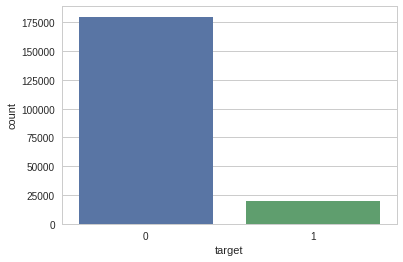

In [0]:
sns.set_style('whitegrid')
sns.countplot(target)
sns.set_style('whitegrid')

In [0]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y



```
# This is formatted as code
```

###Default 0.*90108 second trial*

In [0]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

###Trial 3 https://www.kaggle.com/kwonyoung234/too-many-names-of-params-in-lgbm/log 

In [0]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 31,  #Changed from 13 
    'num_threads': 8,
    'tree_learner': 'voting_parallel',  # from serial
    'objective': 'binary', 
    'verbosity': -1
}

###Trial n

In [0]:
param = {   
  'boosting_type': 'gbdt', 
  'colsample_bytree': 1.0,
  'importance_type': 'split',
  'learning_rate': 0.01,
  'metric':'auc'
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_sum_hessian_in_leaf': 10.0,
  'n_estimators': 100,
  'n_jobs': -1,
  'num_leaves': 31,
  'objective': 'binary',
  
    }

###Trial 2 0.900

In [0]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',   # dart is taking very long time
    #'device_type':'gpu',  
    'feature_fraction': 0.041,
    'learning_rate': 0.007,  #from 0.0083
    'max_depth': 7,   #New
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 80,  #
    'num_threads': 8,
    'tree_learner': 'serial', 
    'objective': 'binary', 
    'verbosity': -1
}

In [0]:
kfold = 20
folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
num_folds = 11
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train_df))
getVal = np.zeros(len(train_df))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

In [0]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    
    X_train, y_train = train_df.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train_df.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912115	valid_1's auc: 0.8965
[10000]	training's auc: 0.922118	valid_1's auc: 0.901062
[15000]	training's auc: 0.929644	valid_1's auc: 0.901892
[20000]	training's auc: 0.936468	valid_1's auc: 0.90184
Early stopping, best iteration is:
[16233]	training's auc: 0.931356	valid_1's auc: 0.902119
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.911929	valid_1's auc: 0.894677
[10000]	training's auc: 0.921727	valid_1's auc: 0.897939
[15000]	training's auc: 0.929252	valid_1's auc: 0.898058
Early stopping, best iteration is:
[12890]	training's auc: 0.926186	valid_1's auc: 0.898242
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912895	valid_1's auc: 0.889255
[10000]	training's auc: 0.9227	valid_1's auc: 0.89271
[15000]	training's auc: 0.930169	valid_1's auc: 0.893175
[20000]	training's auc: 0.9369

In [0]:
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


 >> CV score: 0.90127 


In [0]:
submission = pd.DataFrame({"ID_code": test_df.ID_code.values})
#submission = pd.DataFrame()
submission["target"] = predictions
submission.to_csv("submission_lgbm_trial2.csv", index=False)

In [0]:
submission.head()

,ID_code,target
0,test_0,0.138678
1,test_1,0.274713
2,test_2,0.227017
3,test_3,0.312622
4,test_4,0.057724


###https://www.kaggle.com/jesucristo/santander-magic-lgb-0-901